In [1]:
# Einstellungen fuer Plots

imagewidth = 800
plot_size = (18, 12)
half_plot_size = (18, 6)

In [2]:
%matplotlib inline
import numpy as np
np.random.seed(42)
import pandas as pd
import seaborn as sns
import math

from IPython.display import SVG
from graphviz import Source
from IPython.display import display                               
from ipywidgets import interactive
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree

In [3]:
# Change style according to FH
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

plt.style.use('img/fh_kiel.mplstyle')

from palettable.colorbrewer.qualitative import Paired_8 as q_map

plt.set_cmap(q_map.mpl_colormap)
filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')

blue = '#00305D'
green = '#006A4D'
orange = '#F49E00'
dark_red = '#B5123E'
alarm_red = '#E20020'
light_green = '#7AB51D'

cmap_kiel = ListedColormap(['#00305D', '#F49E00', '#006A4D'])
cmap_kiel2 = ListedColormap(['#00305D', '#F49E00'])


<Figure size 640x480 with 0 Axes>

# Grundlagen Maschinelles Lernen

## Fundamentals of Machine Learning


Prof. Dr.-Ing. Daniel Böhnke

<div style="text-align: right"> Woche 6 </div>

# Die drei Bestandteile des Fehlers

<center><img src="img/tafel_validierung.png" width=60% class="stretch"></center>

$$E\left(Y-\hat{f}(X)\right)^2 = \mathrm{Var}(\hat{f}(X))+ \left[\mathrm{Bias}(\hat{f}(X))\right]^2+ \mathrm{Var}(\epsilon)$$

* Wir sparen uns hier die Herleitung! (Lesehinweis: ISL Kapitel 2.2.2)
* $\mathrm{Var}(\hat{f}(x))$ ist die Varianz unseres Modells: Unser Modell variiert/schwankt stark mit den Trainingsdaten.
* $\left[\mathrm{Bias}(\hat{f}(x))\right]^2$ ist der Bias bzw. die Verzerrung des Modells: Die Annahmen des Modells stimmen nicht.
* $\mathrm{Var}(\epsilon)$ Ursache ist der zufallsbedingte Anteil unserer Daten, diesen Fehler ist nicht reduzierbar. 


# Feature Engineering

<center><img style="float: right;" src="img/tafel_fe.png" width=30% class="stretch"></center>

* Zwei Wege stehen uns zur Verfügung ML-Algorithmen um zu unterstützen:
    * Hyperparameter Tuning
    * Feature Engineering
* Wir setzen Wissen über die Daten und Modelle ein, um neue / bessere Feature ($X$) zu bauen.
* Kombination aus statistischen und fachlichen Methoden
* Die verschiedenen Methoden des Feature Engineering sind abhängig von den vorhandenen Daten anzuwenden. Z.b werden Sie sehen, dass ein Dummy Encoding nur für qualitative Variablen sinnig ist.
* Je nachdem welche Modelle Sie verwenden, haben bestimmte Methoden des Feature Engineering einen Effekt oder nicht. z.B. profitiert k-NN stark von der Skalierung der Daten. Für den Entscheidungsbaum bringt die Skalierung keinen Unterschied. 
* Es ist daher schwer ein allgemeingültiges Beispiel für alle Fälle zu finden

# Skalierung

<center><img src="img/screen_scaling.png" width=50% class="stretch"></center>



* Daten sind in irgendeiner Größenordnung definiert (z.B. kilo, mega, giga etc).
* Daten sind in irgendeiner Einheit definiert (z.B. Zeit in Jahren, Leistung in PS).
* Für die statistische Betrachtung ist dies nicht immer hilfreich.
* Beispiel: Der k-NN berechnet die Distanz zwischen mehreren Attributen ohne eine Kenntnis darüber zu haben, wie die Achsen zueinander skalieren.
* Eine Skalierung aller Attribute ist daher hilfreich.
* Oft verwendete Ansätze:
    * Min/Max 
    * Z-Normalisierung
    * Robustes Skalieren

# SMOTE: Synthetic Minority Over-sampling Technique


<center><img src="img/tafel_smote.png" width=50% class="stretch"></center>


* Gängige Methoden, um Daten der seltenen Klasse aufzufüllen.
* Kann beliebig viele Daten genierieren; in der Regel ganzzahlige Vielfache.
* Basiert auf Nearest Neighbour Logik

# Referenz ohne SMOTE

In [4]:
# Lade Auto-Datensatz 
df = pd.read_csv('Auto.csv')
df['horsepower'] = np.where(df['horsepower']=='?', None, df['horsepower'])
df = df.dropna()
df['horsepower'] = pd.to_numeric(df['horsepower'])
df['fuel_saver'] = np.where(df['mpg']>30, 1, 0)

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier


X = df[['horsepower', 'weight']]
y = df['fuel_saver']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

model_knn_5 = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)
f1_score(y_test, model_knn_5.predict(X_test), average='binary'), sum(y_train)/len(y_train)

(0.5333333333333333, 0.2108626198083067)

# SMOTE in Python

In [6]:
# Zufälliger Startpunkt
fuel_savers = X_train[y_train==1].copy() 
start = fuel_savers.sample()
start_hp = start.horsepower.values[0]
start_w = start.weight.values[0]
start

,horsepower,weight
394,84,2295


In [7]:
# Berechne Neirest Neighbours
fuel_savers['dist'] = np.sqrt((fuel_savers.horsepower-start_hp)**2+(fuel_savers.weight-start_w)**2)
fuel_savers.sort_values(by=['dist']).head(n=3)

,horsepower,weight,dist
394,84,2295,0.00000
321,75,2265,31.32092
381,70,2245,51.92302


In [8]:
 # Neuer Punkt
nn = fuel_savers.sort_values(by=['dist']).values[1]
rand = np.random.rand() # Wähle ein zufällige Zahl zwischen 0-1

neu_hp = start_hp + rand* (nn[0]-start_hp)
neu_w = start_w + rand* (nn[1]-start_w)

print('SMOTE Punkt 1 liegt bei HP: {} und Weight: {}'.format(neu_hp, neu_w) )

SMOTE Punkt 1 liegt bei HP: 83.69050330996303 und Weight: 2293.9683443665435


# SMOTE in Python II

In [9]:
# Und einmal für alle Fuel Saver 
# Entspricht SMOTE 100%, d.h. Verdoppelung der ursprünglichen Daten
fuel_savers = X_train[y_train==1].copy() 

for i, r in fuel_savers.iterrows():
    start_hp = r.horsepower
    start_w = r.weight
    fuel_savers['dist'] = np.sqrt((fuel_savers.horsepower-start_hp)**2+(fuel_savers.weight-start_w)**2)

    nn = fuel_savers.sort_values(by=['dist']).values[1]
    rand = np.random.rand() 
    hp = start_hp + rand* (nn[0]-start_hp)
    w = start_w + rand* (nn[1]-start_w)
    
    X_train = pd.concat([X_train, pd.DataFrame([[hp, w]],columns=X_train.columns)], axis=0, ignore_index=True)
    y_train = pd.concat([y_train, pd.DataFrame([[1]])], axis=0, ignore_index=True)

In [10]:
# Wir nehmen lediglich neue Trainingsdaten!
model_knn_5 = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train.to_numpy().ravel())
f1_score(y_test, model_knn_5.predict(X_test), average='binary'), y_train.sum()[0]/len(y_train)

(0.6285714285714286, 0.3482849604221636)

# Heute

* Mit dem Feature Engineering wurden in der letzten Woche Methoden eingeführt, um die Modelle in ihrer Vorhersage zu unterstützen. 
* Wir sind bis jetzt aber immer noch auf recht einfache Modelle beschränkt. 
* Heute wird daher der **Entscheidungsbaum** eingeführt. Er zeichnet sich insbesondere durch seine hohe Transparenz aus. 
* Der Entscheidungsbaum kann (in der folgenden Veranstaltung) noch erheblich verbessert werden und liefert sehr gute Performance. 
* Des Weiteren wird die Validierung von Modellen angesprochen. 

# Lernlandkarte 
<center><img src="img/lernlandkarte.png" width=80% class="stretch"></center>

# Zum Einstieg: 

* R2D3 hat eine sehr anschauliche Visualisierung von Entscheidungsbäume erstellt. 
* Wir werden im weiteren Verlauf versuchen die dargestellten Konzepte tiefer zu analysieren!

<center><a href="http://www.r2d3.us/visual-intro-to-machine-learning-part-1/"> R2D3 Intro</a> </center>

# Entscheidungsbaum

<center><img style="float: right;" src="img/tafel_baum.png" width=30% class="stretch"></center>

* Der Entscheidungbaum steht auf dem Kopf:
    * Der oberste Knoten ist die Wurzel des Baums.
    * Die untersten Knoten des Entscheidungsbaums sind Blätter.
    * An den Blättern kann das Ergebnis einer Klassifikation abgelesen werden.

* Der Entscheidungsbaum hat eine bestimmte Tiefe $n$ entstprechend den Ebenen im Baum.
* In jedem Knoten wird der Datensatz anhand eines der Parameter aus $X$ an einem bestimmten Schwellwert geteilt.

# Entscheidungen im Entscheidungsbaum

<center><img style="float: right;" src="img/r2d3_split.png" width=30% class="stretch"></center>

* R2D3 hat bereits aufgezeigt, dass es entscheidend ist, die richtigen Entscheidungen zu treffen!
* **Wenn Sie in einem Knoten den Datensatz trennen sollen, welche Eigenschaften sollten die folgenden Knoten aufweisen?**

* Der Knoten sollte möglichst *klassenrein* sein. 
* Der Knoten sollte möglichst viele Daten beinhalten. 

# Gini Index

$$G = \sum_{k=1}^K \hat{p}_{mk}(1-\hat{p}_{mk})$$

* Der Gini Index beschreibt die Klassen-Reinheit eines Knotens.
* Über alle Klassen $k$ wird in der Region (dem Knoten) $m$ die Wahrscheinlichkeit addiert.
* Im besten Fall ist der Gini-Index sehr nah an der 0.
* In unserem einfachen Fall, kommen wir schon mit Abzählen weiter.

In [11]:
# Lade den Auto Datensatz, eliminiere Missing Values
df = pd.read_csv('Auto.csv')
df['horsepower'] = np.where(df['horsepower']=='?', None, df['horsepower'])
df = df.dropna()
df['horsepower'] = pd.to_numeric(df['horsepower']) 
df['weight'] = pd.to_numeric(df['weight'])
df['fuel_saver'] = np.where(df['mpg']>30, 1, 0)

# Beispiel: Gini Fuel Saver

* Autos mit einer hohen Effizienz ($mpg>30$) werden als **Fuel Saver** klassifiziert.
* Wie hoch ist der Gini-Index in unserem Datensatz für den obersten Knoten, d.h. für die gesamten Daten?

$$G = \sum_{k=1}^K \hat{p}_{mk}(1-\hat{p}_{mk})$$


In [12]:
p_fuelsaver = len(df[df.fuel_saver==1])/len(df)
p_fuelwaster = len(df[df.fuel_saver==0])/len(df)

p_fuelwaster, p_fuelsaver

(0.7882653061224489, 0.21173469387755103)

In [35]:
p_fuelwaster = 0.0001
p_fuelsaver = 1 - p_fuelwaster

In [36]:
p_fuelsaver * (1- p_fuelsaver) + p_fuelwaster * (1- p_fuelwaster)

0.000199979999999989

# CART (Classification and Regression Tree)

* In einem Entscheidungsbaum wird in jedem Knoten nach einem Parameter und an einer Schwelle eine Entscheidung getroffen, d.h. die Daten in verschiedene Äste aufgeteilt. 
* Gesucht wird der richtige Parameter $x_{1,\dots,n}$ und der richtige Schwellwert $t$

$$J(l, t_l) = \frac{m_{links}}{m}G_{links} + \frac{m_{rechts}}{m}G_{rechts}$$

* $m$ entspricht der Anzahl der verbleibenden Samples.
* $l$ entspricht dem Index des Parameter, i.e. $x_l$.
* Der Parameter, der das minimale $J$ erreicht, wird für die Entscheidung in einem Knoten gewählt.


# Beispiel CART Fuel Saver

* Wir versuchen den ersten Split für unseren Entscheidungsbaum zu finden.
* Für jeden Parameter (Horsepower, Weight, Displacement) suchen wir das Minimum von $J(l, t_l)$.
* Diskrete Suche ohne Optimierung, d.h. wir werden das Ergebnis nur ungefähr und auch nicht sonderlich schnell treffen.

In [15]:
def gini(df):
    # Wenn der Datensatz keine Elemente enthaelt teilen wir durch null
    if len(df)==0:
        return 1
    
    # Hier unsere ursprüngliche Berechnung
    p_fuel_saver = len(df[df.fuel_saver==1])/len(df)
    p_fuel_waster = len(df[df.fuel_saver==0])/len(df)
    return p_fuel_saver*(1-p_fuel_saver)+p_fuel_waster*(1-p_fuel_waster)

# Suche nach $J$ in Python

In [16]:
thresholds = np.linspace(df.horsepower.min(), df.horsepower.max(), 50)
m = len(df)

for t in thresholds:
    links, rechts = df[df.horsepower<=t], df[df.horsepower>t]
    J = len(links)/m*gini(links)+len(rechts)/m*gini(rechts)
    print("J: {:5.4f} bei t: {:3.1f}HP".format(J, t))


J: 0.3333 bei t: 46.0HP
J: 0.3312 bei t: 49.8HP
J: 0.3207 bei t: 53.5HP
J: 0.3226 bei t: 57.3HP
J: 0.3104 bei t: 61.0HP
J: 0.2980 bei t: 64.8HP
J: 0.2372 bei t: 68.5HP
J: 0.2224 bei t: 72.3HP
J: 0.2026 bei t: 76.0HP
J: 0.2087 bei t: 79.8HP
J: 0.2166 bei t: 83.6HP
J: 0.2282 bei t: 87.3HP
J: 0.2546 bei t: 91.1HP
J: 0.2575 bei t: 94.8HP
J: 0.2746 bei t: 98.6HP
J: 0.2823 bei t: 102.3HP
J: 0.2894 bei t: 106.1HP
J: 0.2905 bei t: 109.8HP
J: 0.3009 bei t: 113.6HP
J: 0.3035 bei t: 117.3HP
J: 0.3051 bei t: 121.1HP
J: 0.3055 bei t: 124.9HP
J: 0.3067 bei t: 128.6HP
J: 0.3071 bei t: 132.4HP
J: 0.3079 bei t: 136.1HP
J: 0.3094 bei t: 139.9HP
J: 0.3122 bei t: 143.6HP
J: 0.3147 bei t: 147.4HP
J: 0.3222 bei t: 151.1HP
J: 0.3230 bei t: 154.9HP
J: 0.3239 bei t: 158.7HP
J: 0.3245 bei t: 162.4HP
J: 0.3256 bei t: 166.2HP
J: 0.3258 bei t: 169.9HP
J: 0.3272 bei t: 173.7HP
J: 0.3285 bei t: 177.4HP
J: 0.3297 bei t: 181.2HP
J: 0.3297 bei t: 184.9HP
J: 0.3297 bei t: 188.7HP
J: 0.3305 bei t: 192.4HP
J: 0.3307 bei t

# J(t) für den Autodatensatz

* Wo setzen Sie den Trenner für Ihren Entscheidungsbaum?

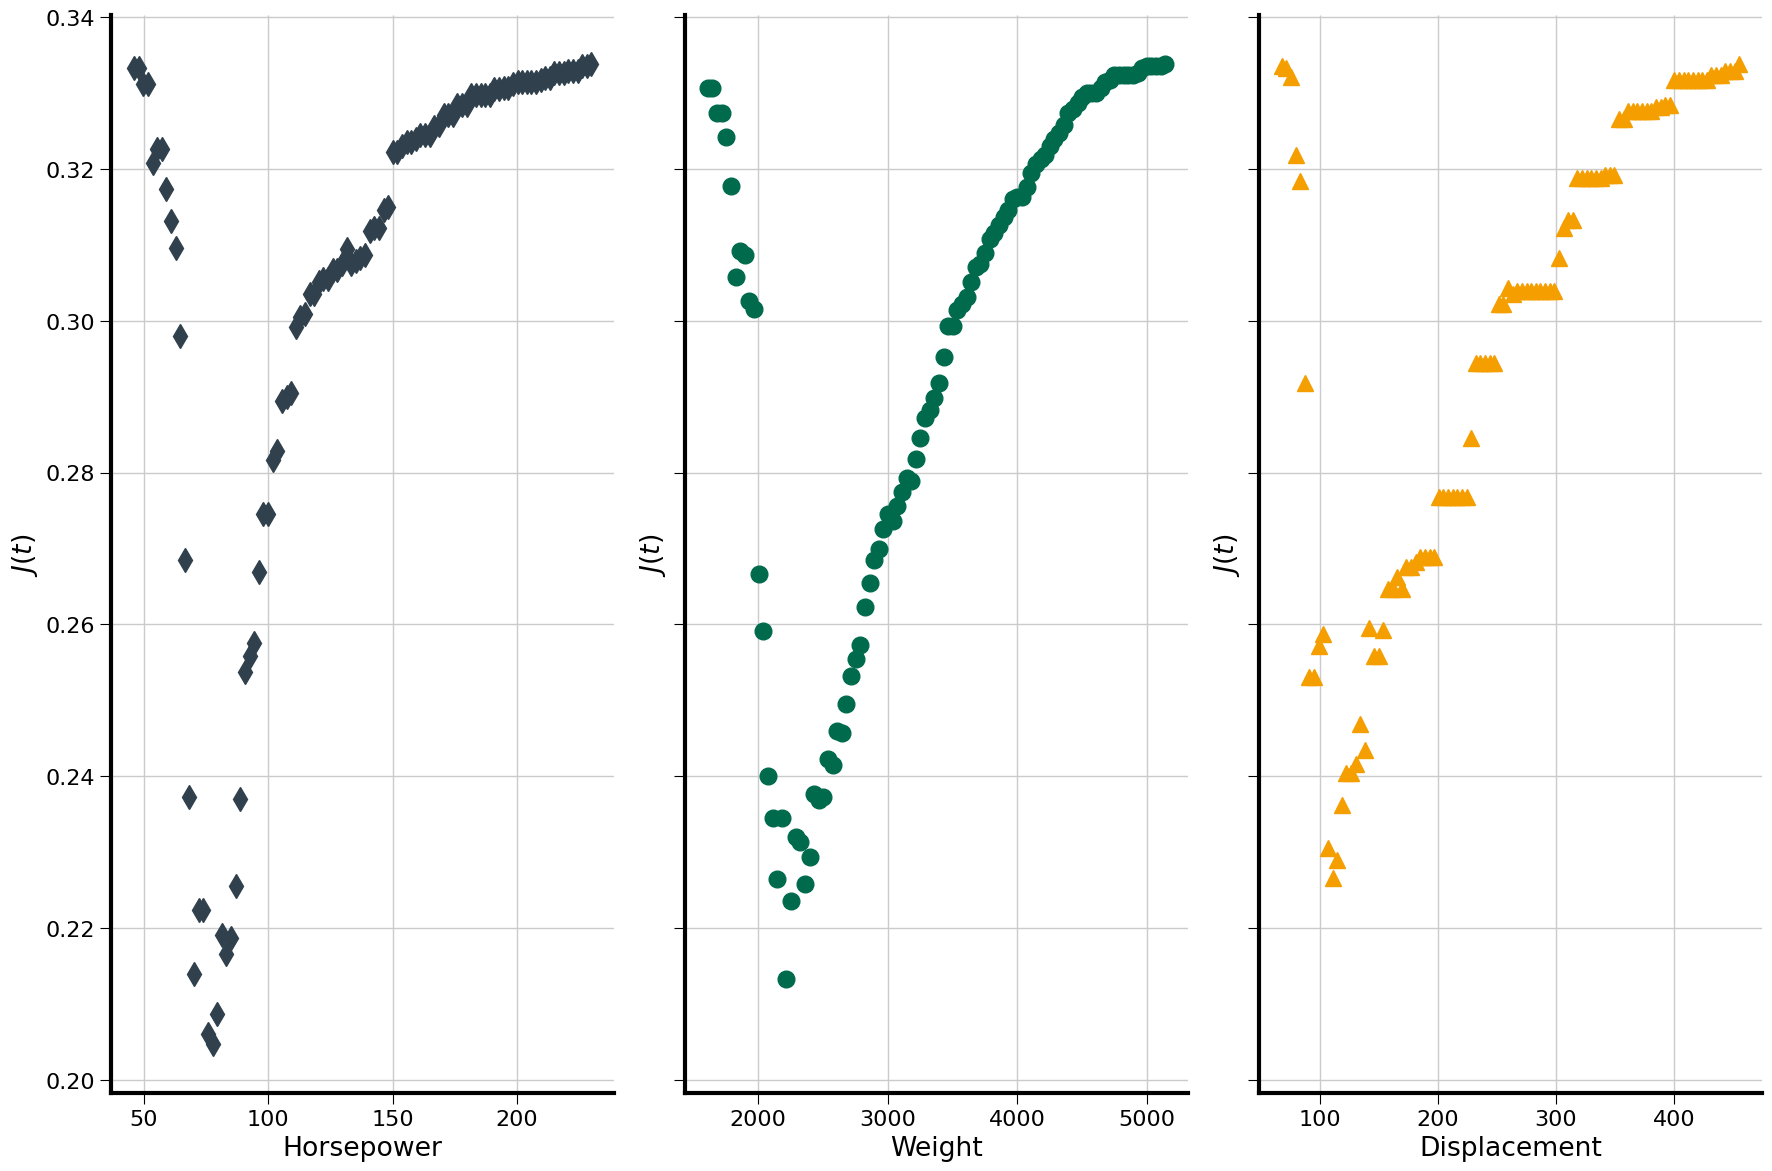

In [17]:
m = len(df)
fig, ax = plt.subplots(1, 3, figsize=plot_size, sharey='all')

Js = []
thresholds = np.linspace(df.horsepower.min(), df.horsepower.max(), 100)
for t in thresholds:
    links, rechts = df[df.horsepower<=t], df[df.horsepower>t]
    J = len(links)/m*gini(links)+len(rechts)/m*gini(rechts)
    Js.append(J)
ax[0].plot(thresholds,Js, 'd' )
ax[0].set_xlabel('Horsepower')
ax[0].set_ylabel('$J(t)$')

Js = []
thresholds = np.linspace(df.weight.min(), df.weight.max(), 100)
for t in thresholds:
    links, rechts = df[df.weight<=t], df[df.weight>t]
    J = len(links)/m*gini(links)+len(rechts)/m*gini(rechts)
    Js.append(J)
ax[1].plot(thresholds,Js, 'o', c=green )
ax[1].set_xlabel('Weight')
ax[1].set_ylabel('$J(t)$')

Js = []
thresholds = np.linspace(df.displacement.min(), df.displacement.max(), 100)
for t in thresholds:
    links, rechts = df[df.displacement<=t], df[df.displacement>t]
    J = len(links)/m*gini(links)+len(rechts)/m*gini(rechts)
    Js.append(J)
ax[2].plot(thresholds,Js, '^', c=orange )    
ax[2].set_xlabel('Displacement')
ax[2].set_ylabel('$J(t)$')

plt.tight_layout()
plt.show()

# Entscheidungsbaum Beispiel

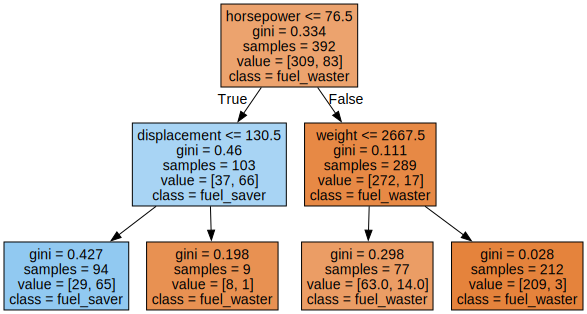

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

In [18]:
df = pd.read_csv('Auto.csv')
df['horsepower'] = np.where(df['horsepower']=='?', None, df['horsepower'])
df = df.dropna()
df['horsepower'] = pd.to_numeric(df['horsepower'])
df['weight'] = pd.to_numeric(df['weight'])
df['fuel_saver'] = np.where(df['mpg']>30, 1, 0)
# feature matrix
X = df[['horsepower', 'weight', 'displacement']]

# target vector
y = df['fuel_saver']

# class labels
labels = ['horsepower', 'weight', 'displacement']
def plot_tree(crit,  depth=2,  min_leaf=1):

    estimator = DecisionTreeClassifier(random_state = 0 , criterion = crit, max_depth = depth, min_samples_leaf=min_leaf)
    estimator.fit(X, y)

    graph = Source(tree.export_graphviz(estimator
      , out_file=None
      , feature_names=labels
      , class_names=['fuel_waster', 'fuel_saver']
      , filled = True))
   
    display(SVG(graph.pipe(format='svg')))
    return estimator

inter=interactive(plot_tree 
   , crit = ["gini", "entropy"]
   , depth=[1,2,3,4]
   , min_leaf=range(100))

display(inter)

# Entscheidungsbaum in Python

* Für den Entscheidungsbaum wird wieder Scikit-learn eingesetzt. 
* Die Hyperparameter werden wir z.T. noch untersuchen. Leider unterscheiden diese sich zum Teil erheblich von der Implementierung in KNIME. 

In [19]:
# feature matrix
X = df[['horsepower', 'weight']]

# target vector
y = df['fuel_saver']

# class labels
labels = ['horsepower', 'weight']

estimator = DecisionTreeClassifier(random_state = 0 , 
                                   criterion = 'gini', 
                                   max_depth = 2, 
                                   min_samples_split=0.0001,
                                   min_samples_leaf=0.0001)
estimator.fit(X, y)

DecisionTreeClassifier(max_depth=2, min_samples_leaf=0.0001,
                       min_samples_split=0.0001, random_state=0)

# Entscheidungsgrenze für den Entscheidungsbaum

/Users/dboehnke/VirtualEnvs/FunML/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


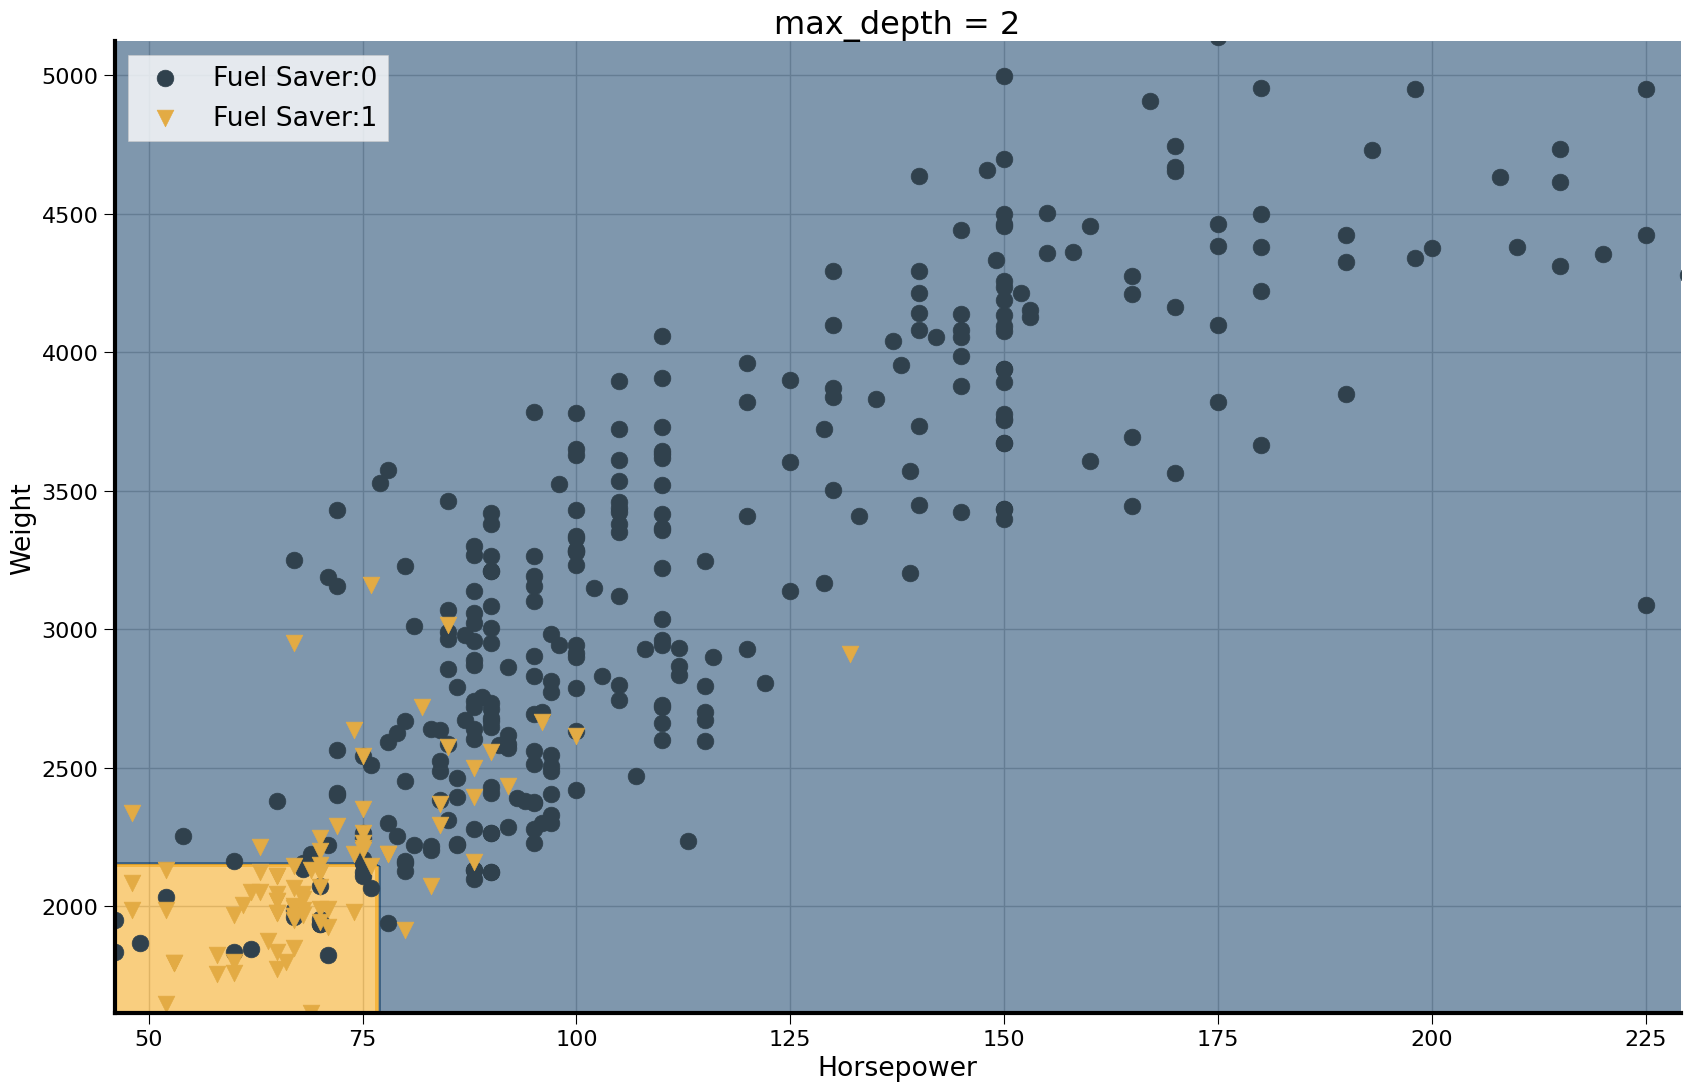

In [20]:
# Plotte die Entscheidungsgrenze
fig, ax = plt.subplots(1, 1, figsize=plot_size)

x_min, x_max = df['horsepower'].min(), df['horsepower'].max()
y_min, y_max = df['weight'].min(), df['weight'].max()
n = 200  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/n), np.arange(y_min, y_max, (y_max-y_min)/n))
Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cmap_kiel2, alpha = 0.5)

# Plot also the training points
for i in range(2):
    plt.scatter(df[df['fuel_saver'] == i].horsepower, df[df['fuel_saver'] == i].weight, marker=filled_markers[i], label='Fuel Saver:' + str(i))

plt.title('max_depth = 2')
plt.ylabel('Weight')
plt.xlabel('Horsepower')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
ax.legend()
plt.show()

# Hyperparmeter Entscheidungsbäume

<center><img src="img/hyperparameter_entscheidungsbaum.png" width=60% class="stretch"></center>

* Ein Hyperparameter ist ein Wert des Modells, den wir einstellen und nicht trainieren.
* Hyperparameter beeinflußen das Model und seine Performance stark. 


# Entscheidungsbaum mit Tiefe 3


* Die maximale Tiefe entspricht der maximalen Anzahl von Entscheidungen, die getroffen werden, bis ein Blatt erreicht wird.
* Wir variieren *Max_Depth* von 2 - 15:

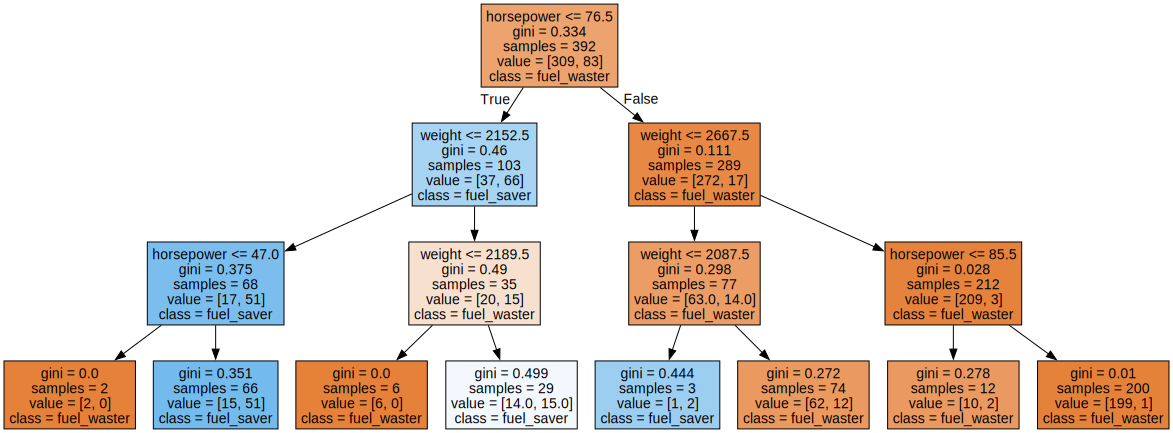

In [21]:
# feature matrix
X = df[['horsepower', 'weight']]

# target vector
y = df['fuel_saver']

# class labels
labels = ['horsepower', 'weight']

estimator = DecisionTreeClassifier(random_state = 0 , criterion = 'gini', max_depth = 3, min_samples_split=0.0001, min_samples_leaf=0.0001)
estimator.fit(X, y)

graph = Source(tree.export_graphviz(estimator, out_file=None
   , feature_names=labels, class_names=['fuel_waster', 'fuel_saver'] 
   , filled = True))

display(SVG(graph.pipe(format='svg')))

# Entscheidungsbaum mit Tiefe 3

/Users/dboehnke/VirtualEnvs/FunML/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


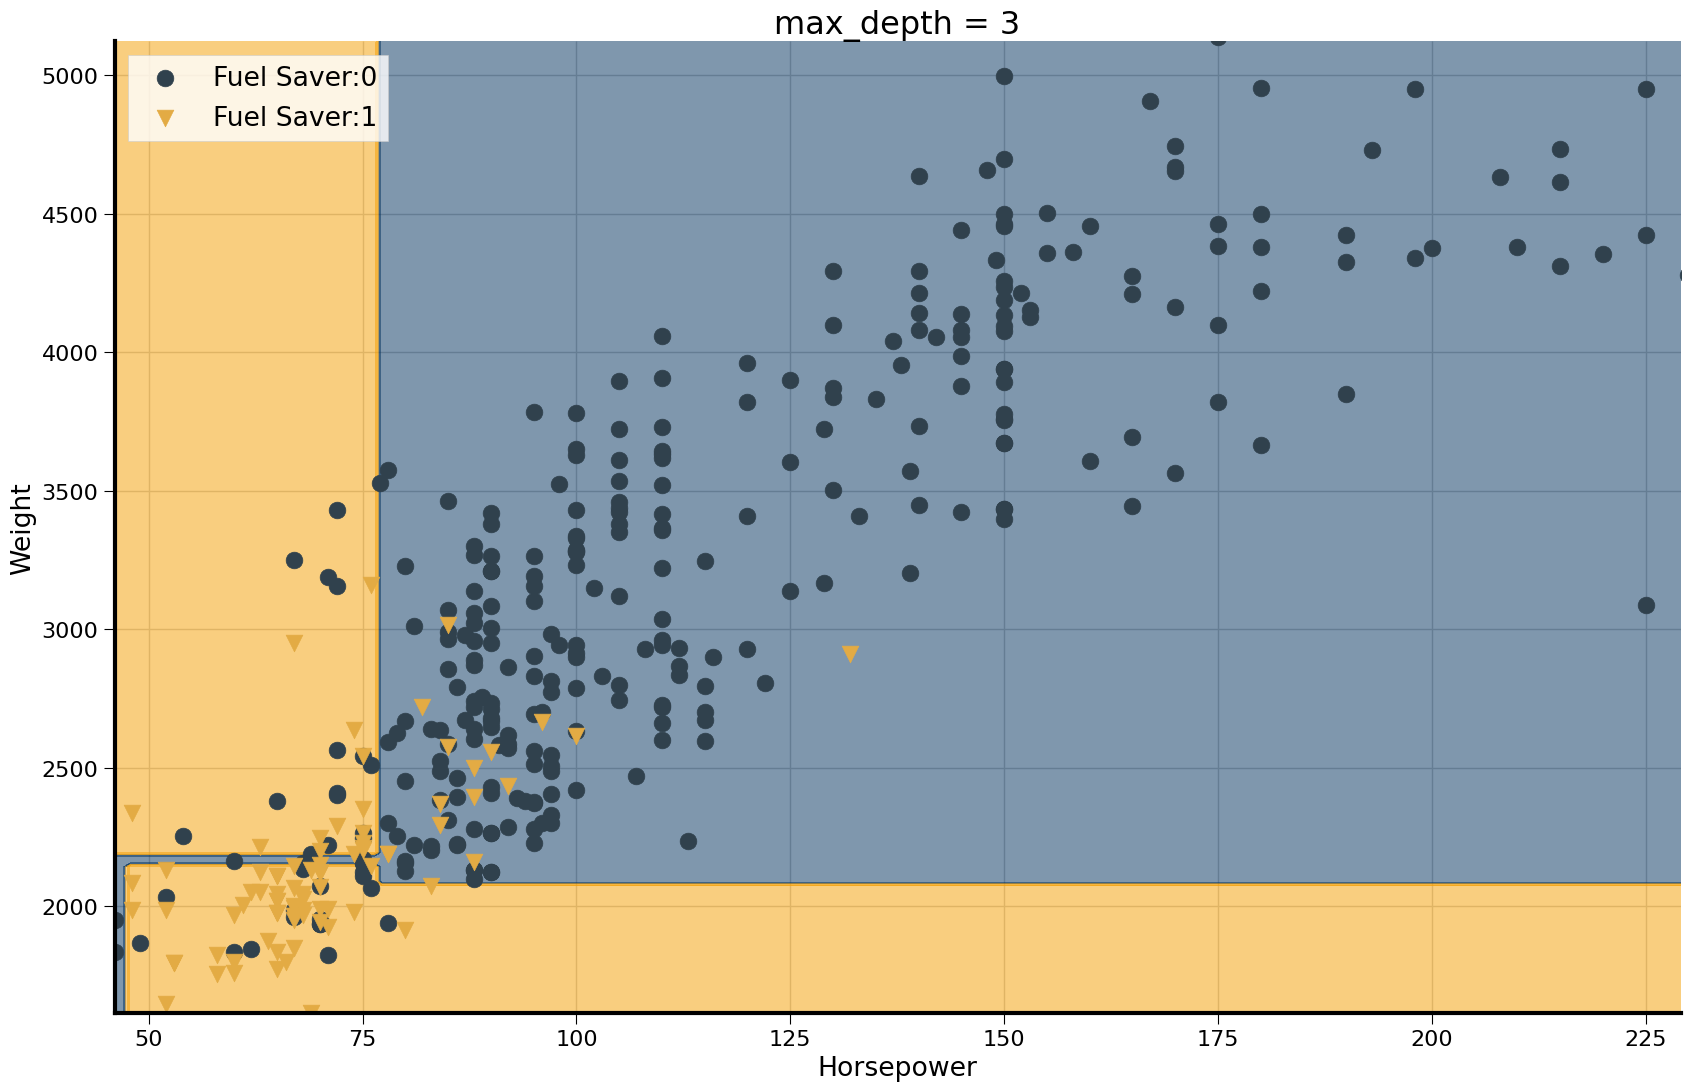

In [22]:
# Plotte die Entscheidungsgrenze
fig, ax = plt.subplots(1, 1, figsize=plot_size)

x_min, x_max = df['horsepower'].min(), df['horsepower'].max()
y_min, y_max = df['weight'].min(), df['weight'].max()
n = 200  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/n), np.arange(y_min, y_max, (y_max-y_min)/n))
Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cmap_kiel2, alpha = 0.5)

# Plot also the training points
for i in range(2):
    plt.scatter(df[df['fuel_saver'] == i].horsepower, df[df['fuel_saver'] == i].weight, marker=filled_markers[i], label='Fuel Saver:' + str(i))

plt.title('max_depth = 3')
plt.ylabel('Weight')
plt.xlabel('Horsepower')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
ax.legend()
plt.show()

# Entscheidungsbaum mit Tiefe 15

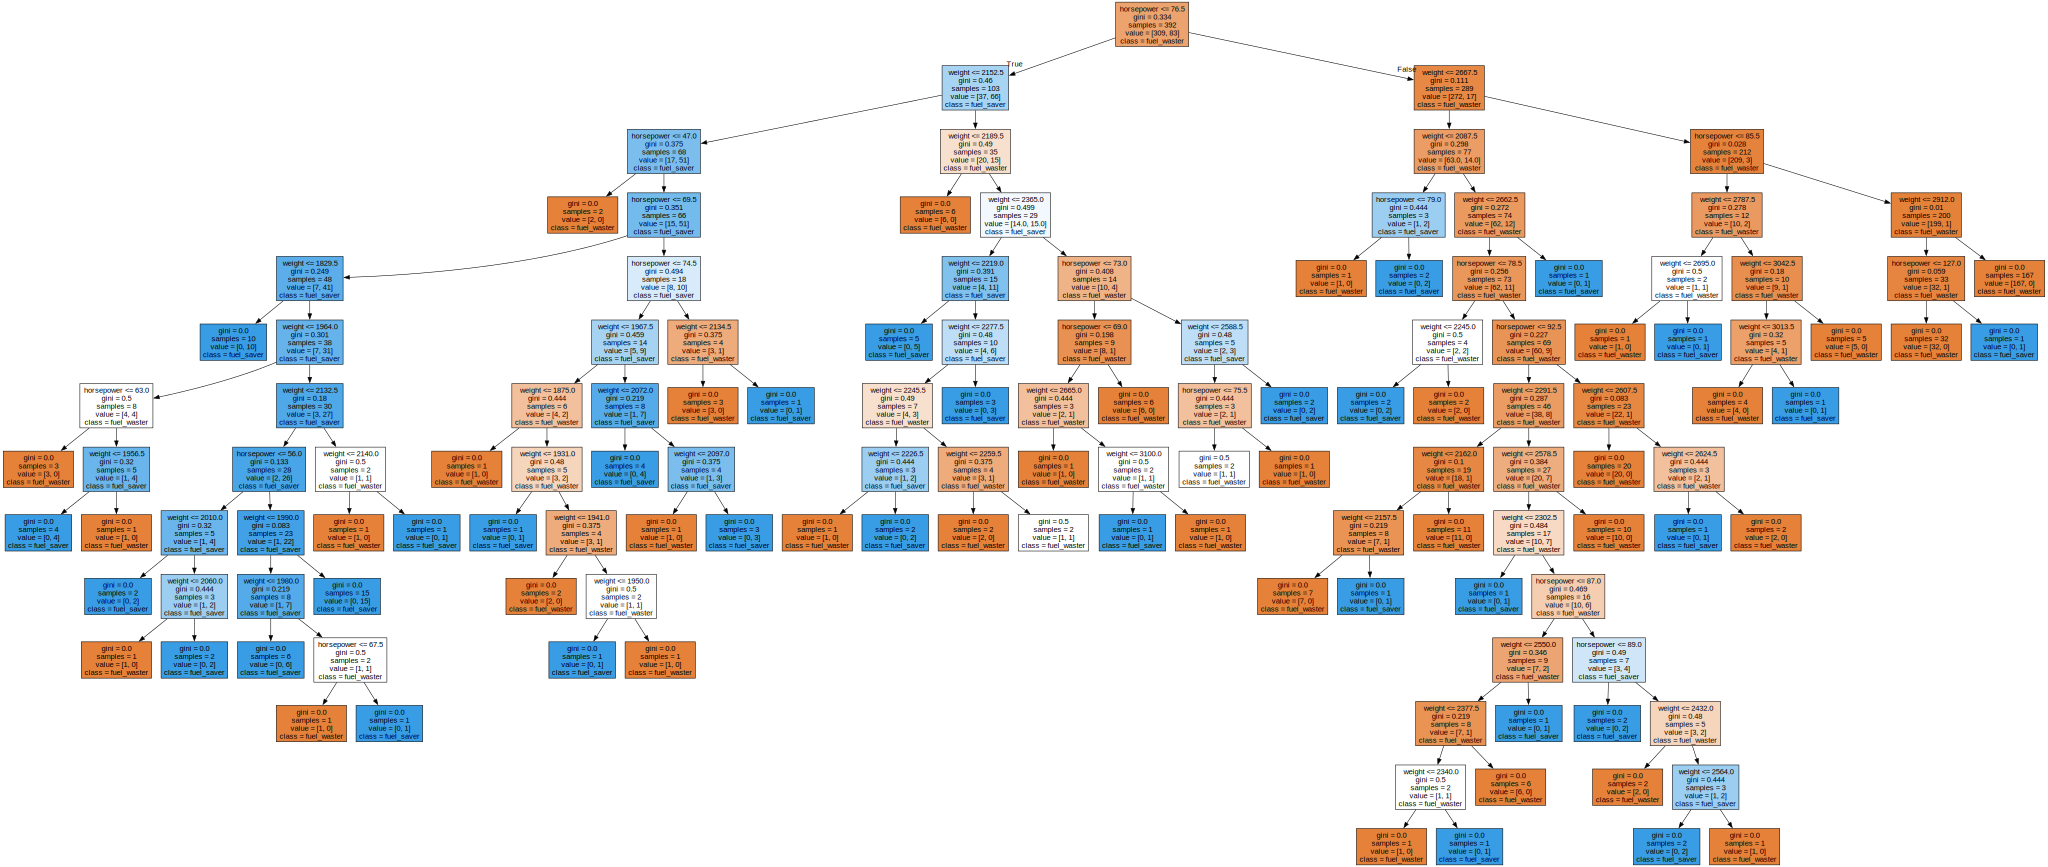

In [23]:
# feature matrix
X = df[['horsepower', 'weight']]

# target vector
y = df['fuel_saver']

# class labels
labels = ['horsepower', 'weight']

estimator = DecisionTreeClassifier(random_state = 0 , criterion = 'gini', max_depth = 15, min_samples_split=0.0001, min_samples_leaf=0.0001)
estimator.fit(X, y)

graph = Source(tree.export_graphviz(estimator, out_file=None
   , feature_names=labels, class_names=['fuel_waster', 'fuel_saver'] 
   , filled = True))

display(SVG(graph.pipe(format='svg')))

# Entscheidungsbaum mit Tiefe 15

/Users/dboehnke/VirtualEnvs/FunML/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


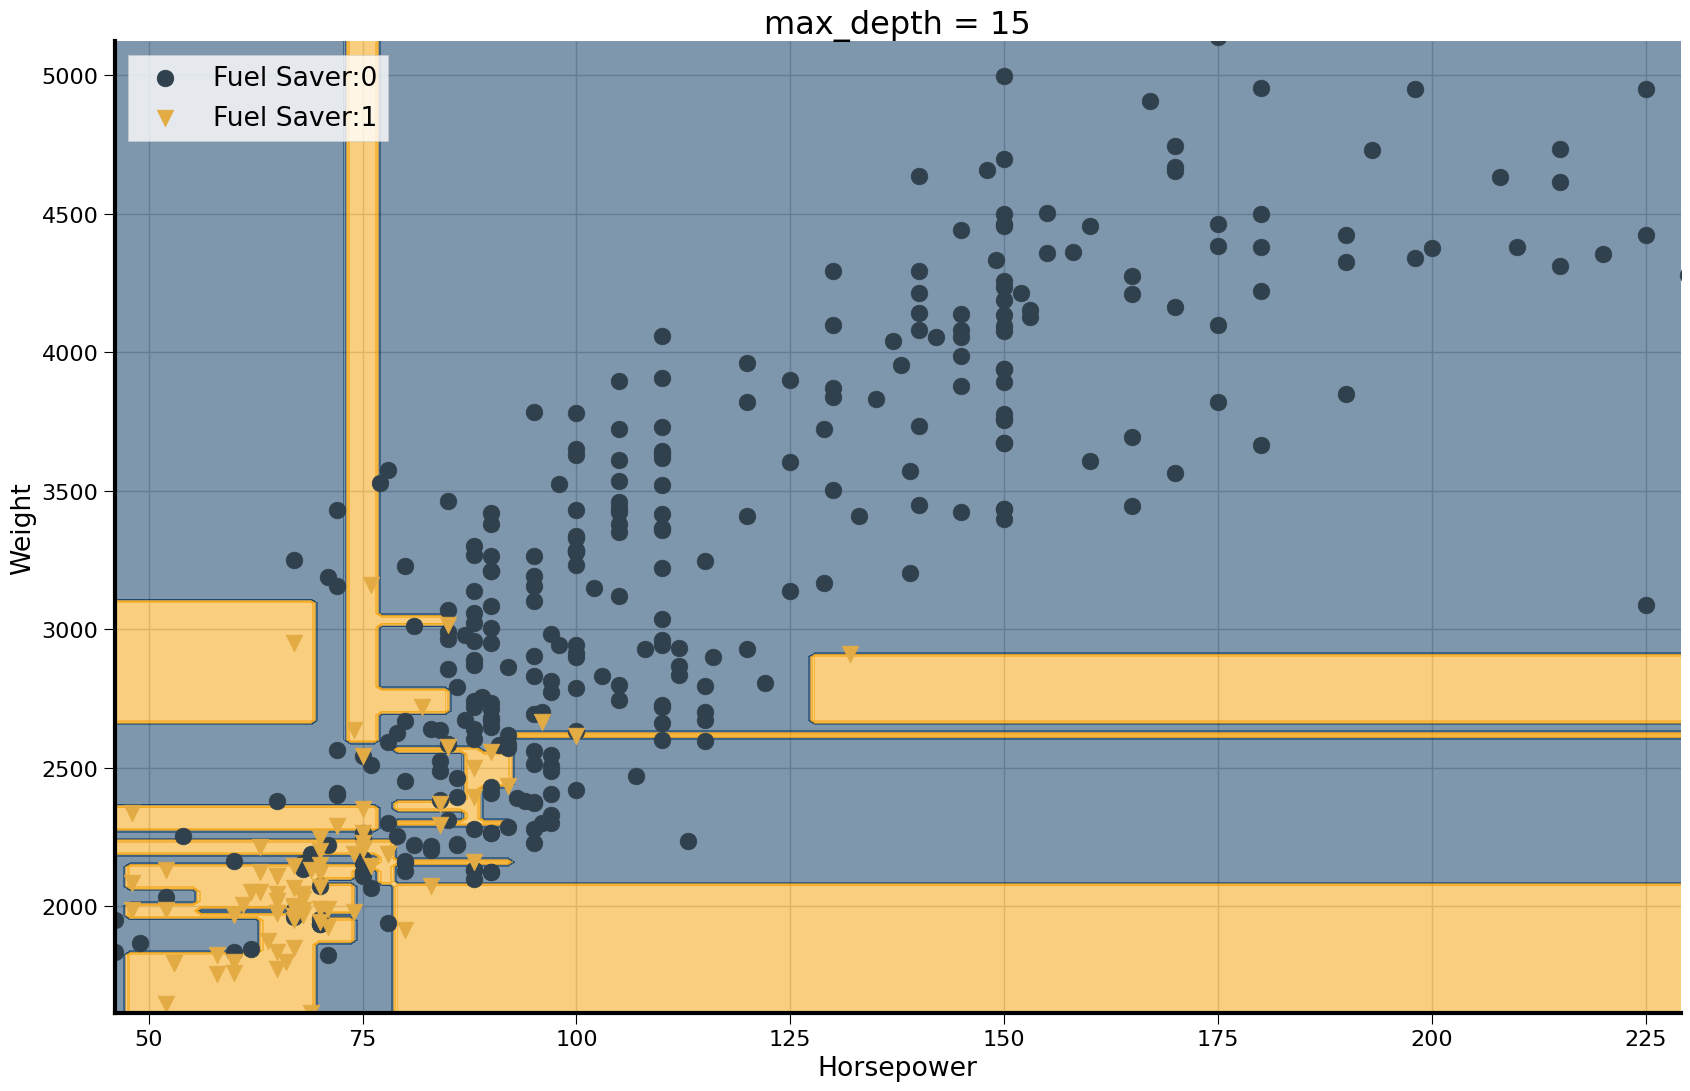

In [24]:
# Plotte die Entscheidungsgrenze
fig, ax = plt.subplots(1, 1, figsize=plot_size)

x_min, x_max = df['horsepower'].min(), df['horsepower'].max()
y_min, y_max = df['weight'].min(), df['weight'].max()
n = 200  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/n), np.arange(y_min, y_max, (y_max-y_min)/n))
Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cmap_kiel2, alpha = 0.5)

# Plot also the training points
for i in range(2):
    plt.scatter(df[df['fuel_saver'] == i].horsepower, df[df['fuel_saver'] == i].weight, marker=filled_markers[i], label='Fuel Saver:' + str(i))

plt.title('max_depth = 15')
plt.ylabel('Weight')
plt.xlabel('Horsepower')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
ax.legend()
plt.show()

# Validierung Entscheidungsbaum

* Wir splitten den Datensatz in Trainings- und Test-Daten: 
    * stratified 
    * 80%, 20%
* Der F1-Score wird für beide Datensätze berechnet.
* Die maximale Tiefe wird von 2 - 15 variiert und die Ergebnisse beobachtet.
* Das Modell mit dem höchsten Score für die Test-Daten ist für uns relevant.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# feature matrix
X = df[['horsepower', 'weight']]

# target vector
y = df['fuel_saver']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

test_f1 = []
train_f1 = []
depth = range(2,16)
for d in depth:
    estimator = DecisionTreeClassifier(random_state = 0 , criterion = 'gini', max_depth = d, min_samples_split=0.0001, min_samples_leaf=1)
    estimator.fit(X_train, y_train)
    test_f1.append(f1_score(y_test, estimator.predict(X_test)))
    train_f1.append(f1_score(y_train, estimator.predict(X_train)))
                    

# F1-Score für Test und Trainingsdaten

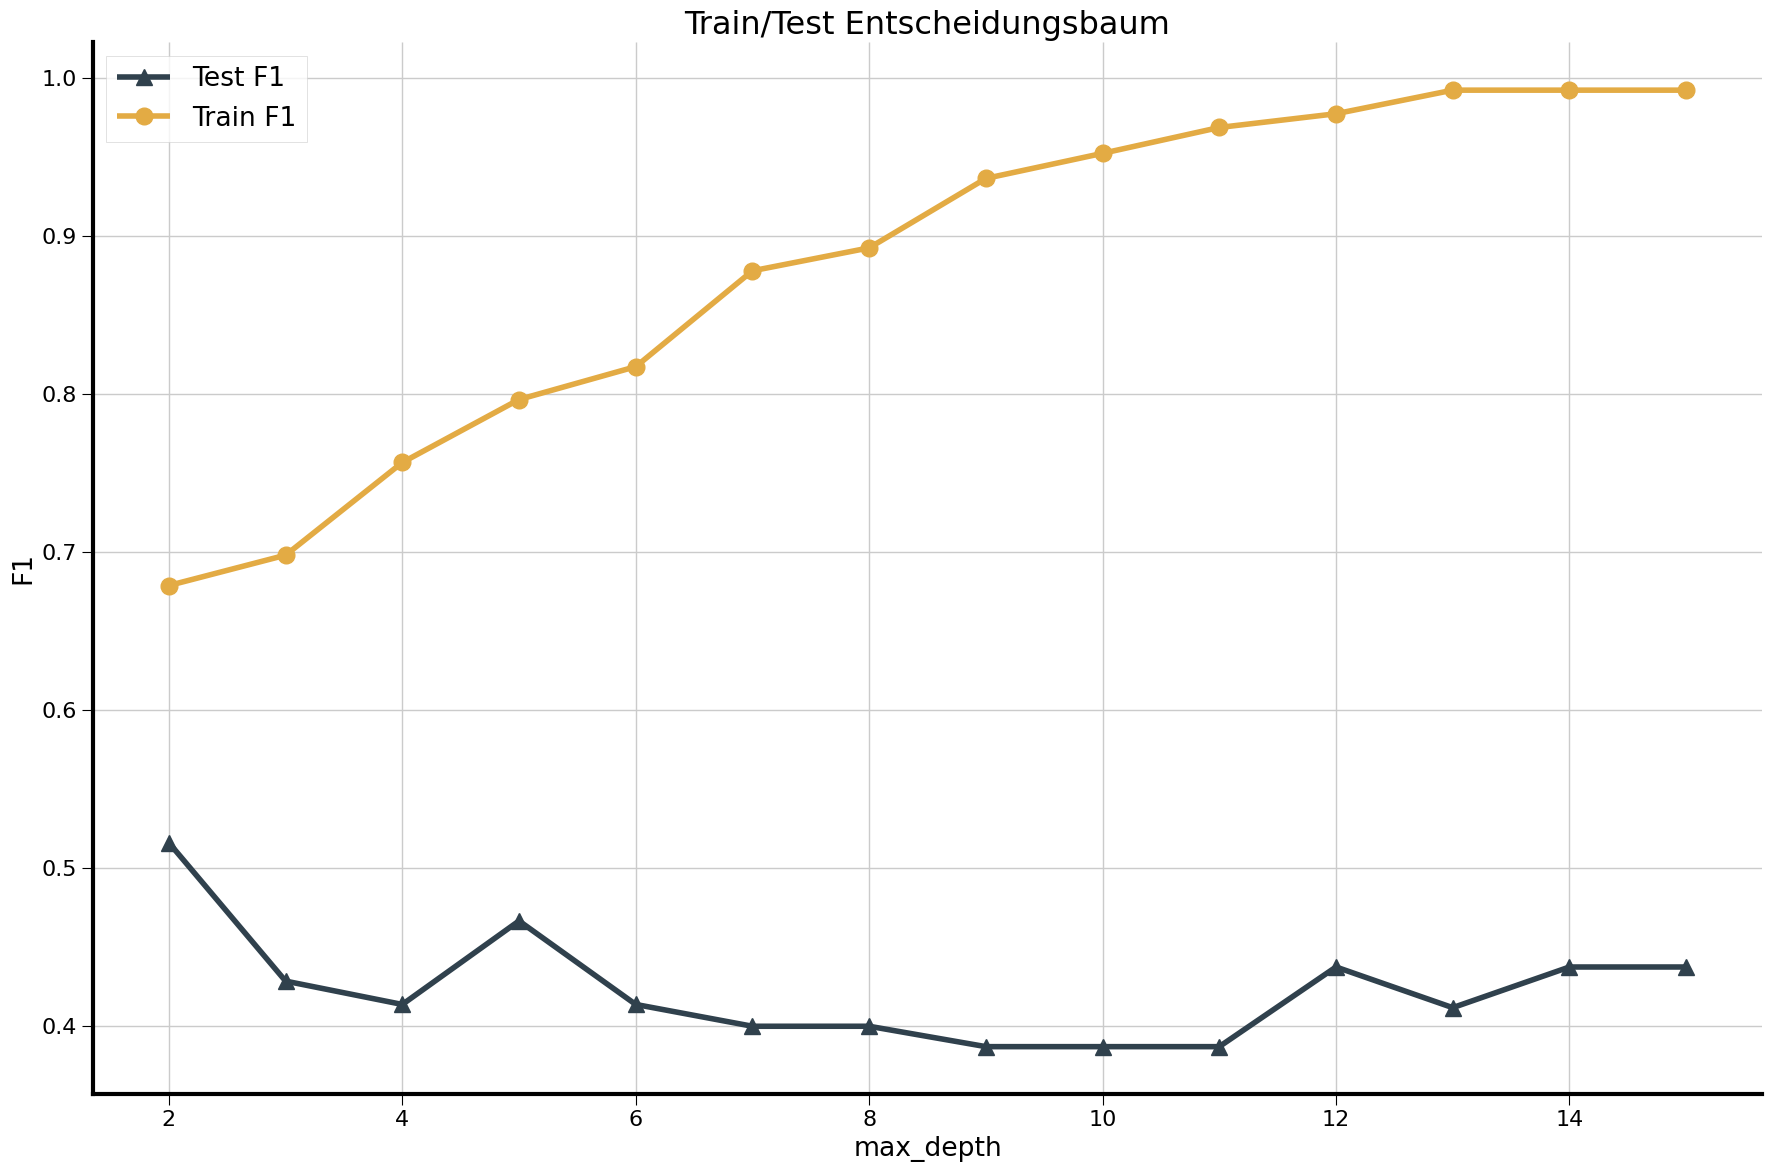

In [26]:
# Plotte Lineare Regression für Elektro Motor
fig, ax = plt.subplots(1, 1, figsize=plot_size)

ax.plot(depth,test_f1, '-^',label='Test F1' )
ax.plot(depth,train_f1, '-o',label='Train F1' )

ax.legend()
plt.title('Train/Test Entscheidungsbaum')
plt.ylabel('F1')
plt.xlabel('max_depth')
plt.tight_layout()
plt.show()

# Maximum Depth 

* Desto größer die zulässige Tiefe, desto eher  kommt es zu einem Overfit.
* Im Extremfall bleibt für jedes Sample ein eigenes Blatt übrig.
* Option 1: Wir erhöhen die maximale Tiefe bis der Test-Score stagniert.
* Option 2: Wir erlauben nur Splits, wenn die resultierenden Blätter eine minimale Anzahl von Samplen nicht unterschreiten.

# Max-Depth = 3 und Min_Leaf = 1

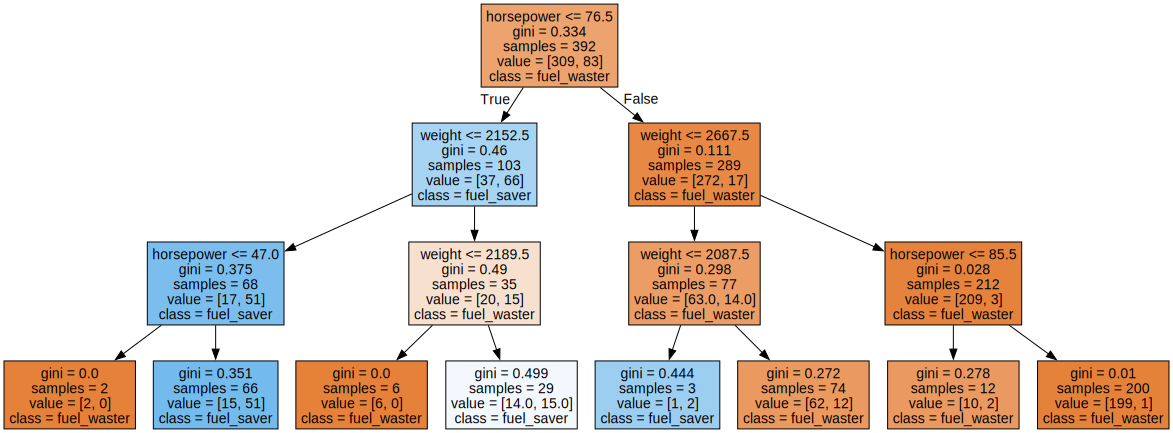

In [27]:
# feature matrix
X = df[['horsepower', 'weight']]

# target vector
y = df['fuel_saver']

# class labels
labels = ['horsepower', 'weight']

estimator = DecisionTreeClassifier(random_state = 0 , criterion = 'gini', max_depth = 3, min_samples_split=0.0001, min_samples_leaf=1)
estimator.fit(X, y)

graph = Source(tree.export_graphviz(estimator, out_file=None
   , feature_names=labels, class_names=['fuel_waster', 'fuel_saver'] 
   , filled = True))

display(SVG(graph.pipe(format='svg')))

# Max-Depth = 3 und Min_Leaf = 1

/Users/dboehnke/VirtualEnvs/FunML/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


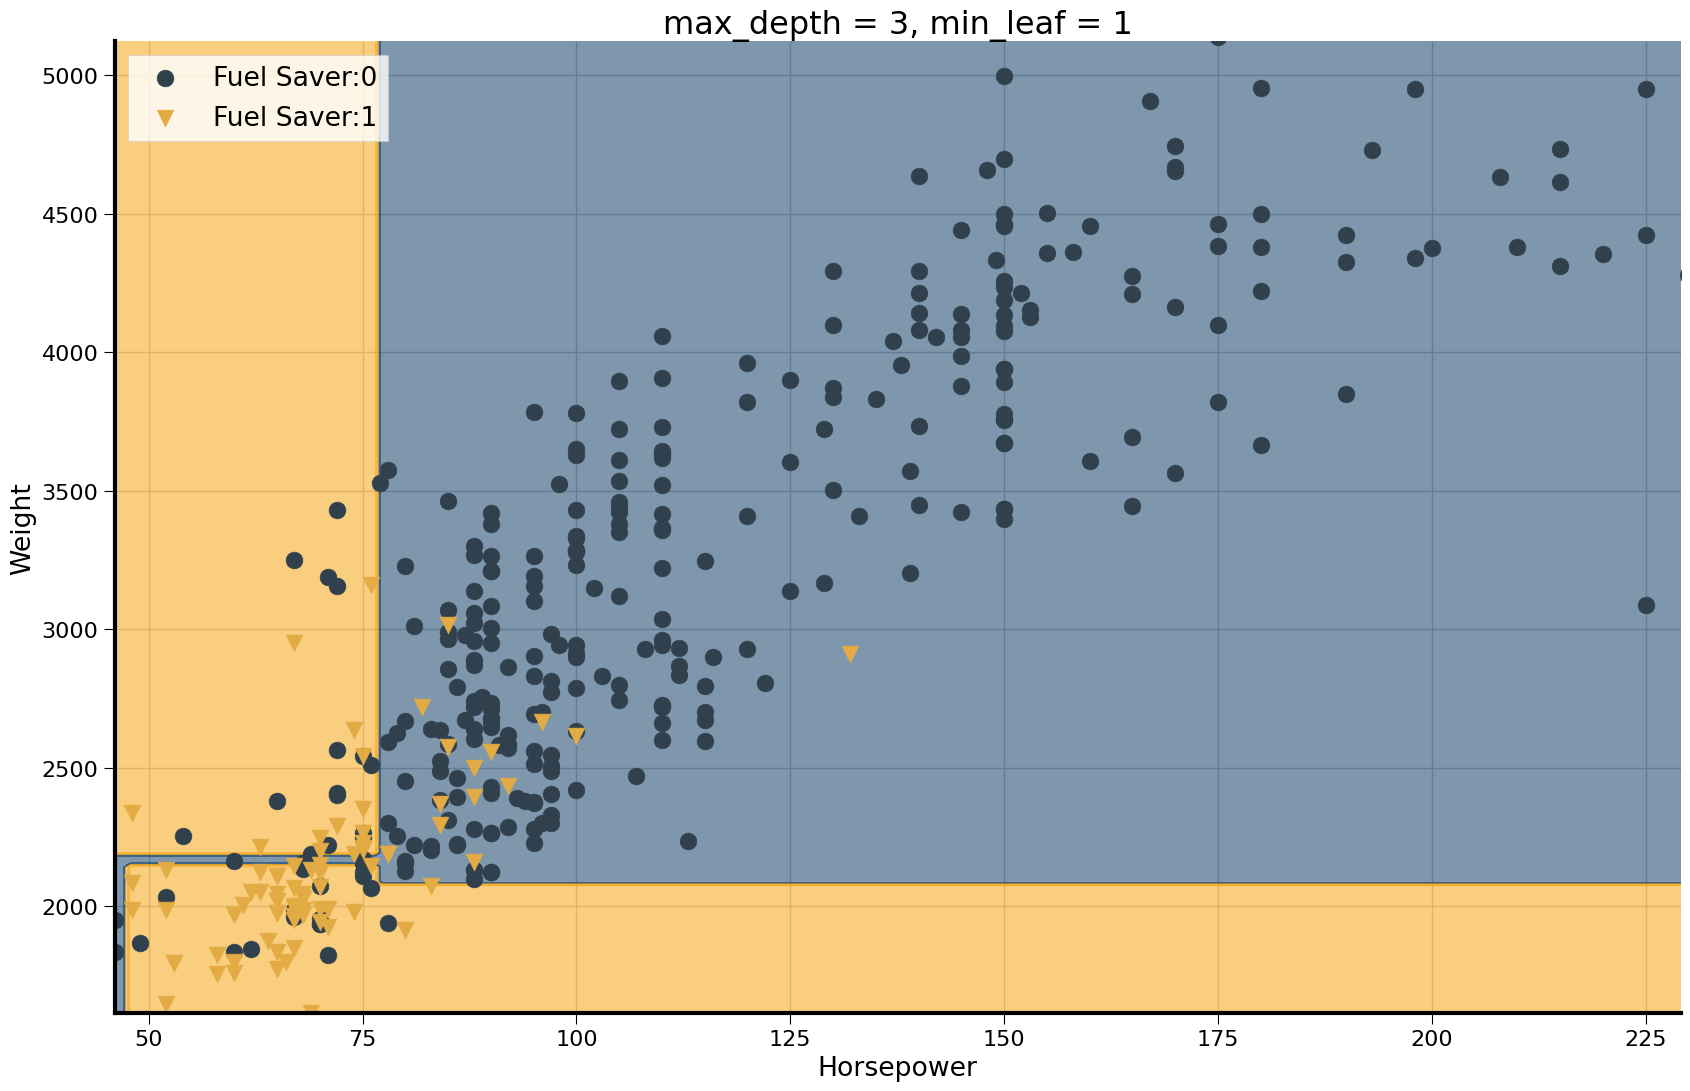

In [28]:
# Plotte die Entscheidungsgrenze
fig, ax = plt.subplots(1, 1, figsize=plot_size)

x_min, x_max = df['horsepower'].min(), df['horsepower'].max()
y_min, y_max = df['weight'].min(), df['weight'].max()
n = 200  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/n), np.arange(y_min, y_max, (y_max-y_min)/n))
Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cmap_kiel2, alpha = 0.5)

# Plot also the training points
for i in range(2):
    plt.scatter(df[df['fuel_saver'] == i].horsepower, df[df['fuel_saver'] == i].weight, marker=filled_markers[i], label='Fuel Saver:' + str(i))

plt.title('max_depth = 3, min_leaf = 1')
plt.ylabel('Weight')
plt.xlabel('Horsepower')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
ax.legend()
plt.show()

# Max-Depth = 3 und Min_Leaf = 10% der Sample

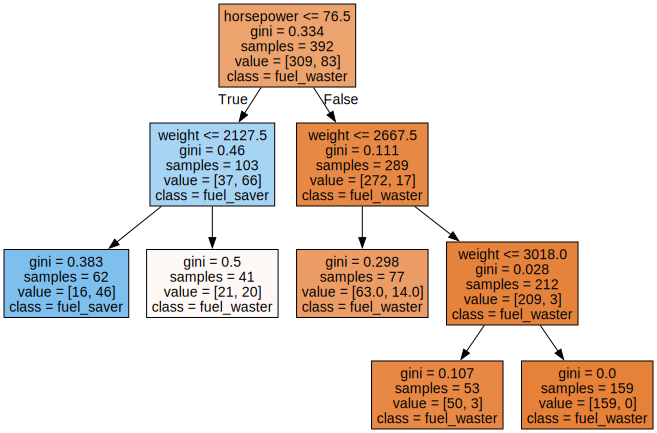

In [29]:
# feature matrix
X = df[['horsepower', 'weight']]

# target vector
y = df['fuel_saver']

# class labels
labels = ['horsepower', 'weight']

estimator = DecisionTreeClassifier(random_state = 0 , criterion = 'gini', max_depth = 3, min_samples_split=0.0001, min_samples_leaf=0.1)
estimator.fit(X, y)

graph = Source(tree.export_graphviz(estimator, out_file=None
   , feature_names=labels, class_names=['fuel_waster', 'fuel_saver'] 
   , filled = True))

display(SVG(graph.pipe(format='svg')))

# Max-Depth = 3 und Min_Leaf = 10% der Sample

/Users/dboehnke/VirtualEnvs/FunML/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


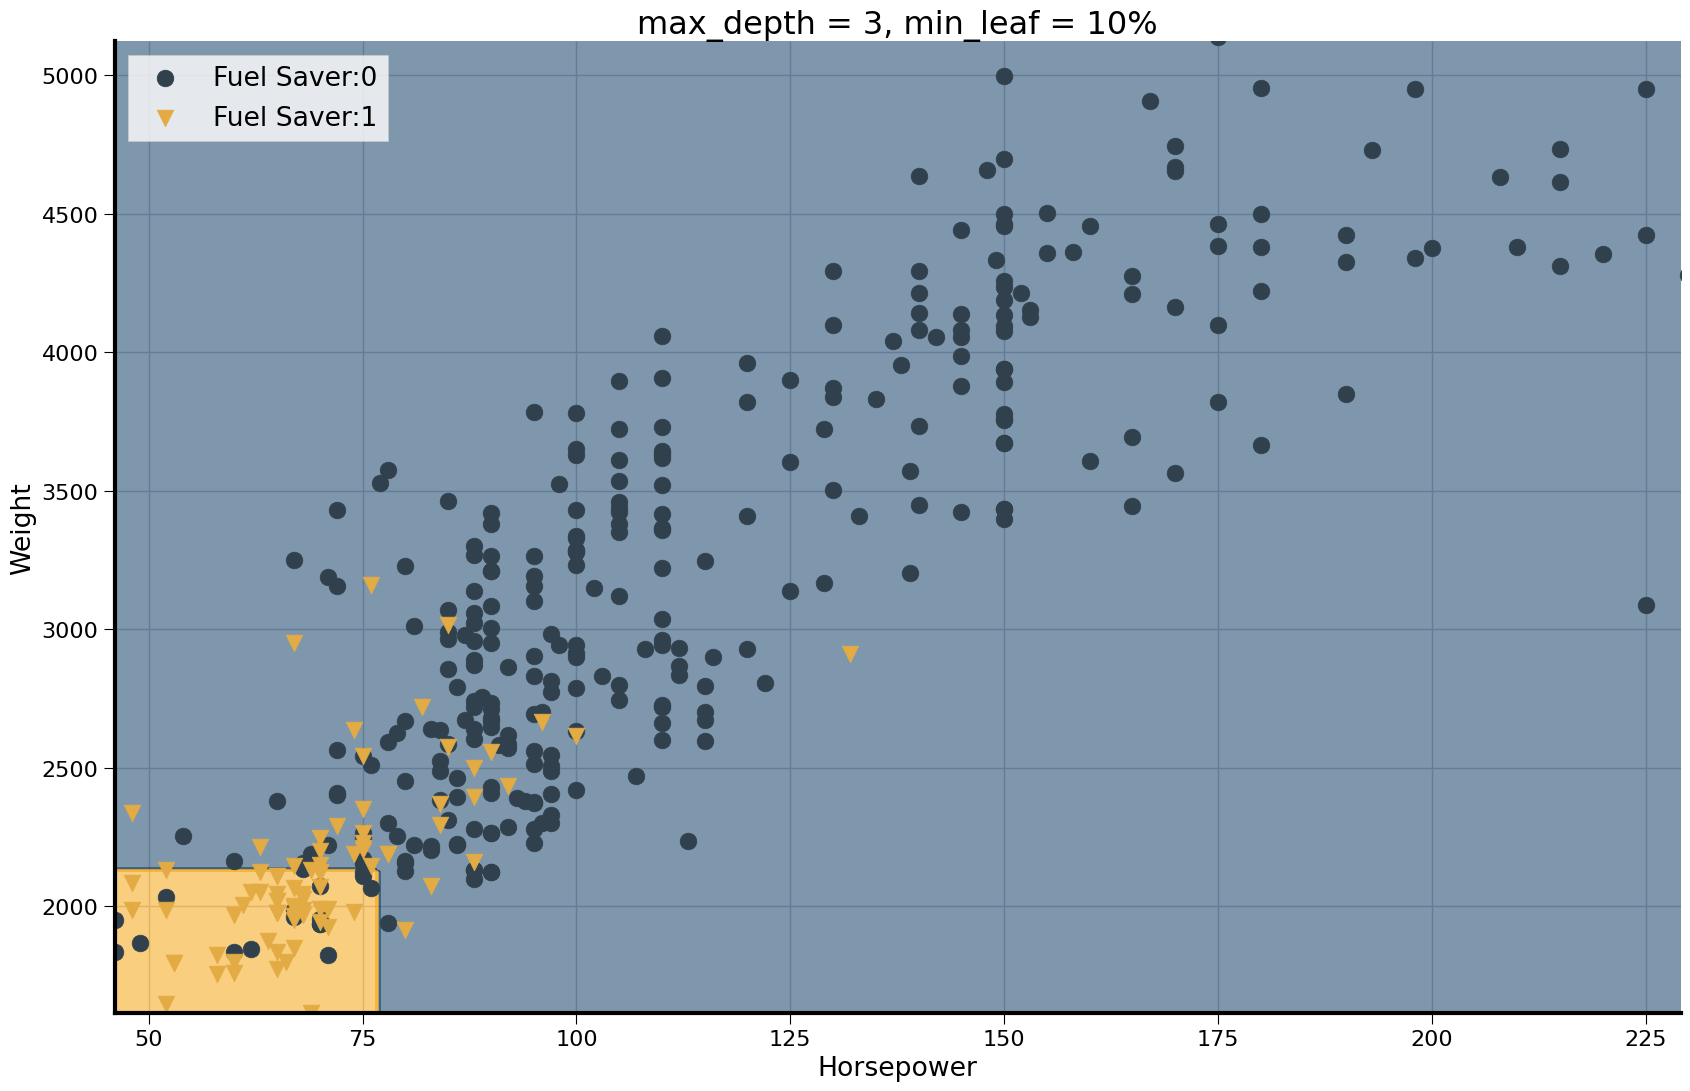

In [30]:
# Plotte die Entscheidungsgrenze
fig, ax = plt.subplots(1, 1, figsize=plot_size)

x_min, x_max = df['horsepower'].min(), df['horsepower'].max()
y_min, y_max = df['weight'].min(), df['weight'].max()
n = 200  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, (x_max-x_min)/n), np.arange(y_min, y_max, (y_max-y_min)/n))
Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=cmap_kiel2, alpha = 0.5)

# Plot also the training points
for i in range(2):
    plt.scatter(df[df['fuel_saver'] == i].horsepower, df[df['fuel_saver'] == i].weight, marker=filled_markers[i], label='Fuel Saver:' + str(i))

plt.title('max_depth = 3, min_leaf = 10%')
plt.ylabel('Weight')
plt.xlabel('Horsepower')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
ax.legend()
plt.show()

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# feature matrix
X = df[['horsepower', 'weight', 'mpg', 'displacement', 'cylinders']]

# target vector
y = df['origin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

depth = range(2,16)
min_leaf = [0.00001, 0.01, 0.025]
train_all = []
test_all = []

for l in min_leaf:
    test_f1 = []
    train_f1 = []
    for d in depth:
        estimator = DecisionTreeClassifier(random_state = 0 , criterion = 'gini', max_depth = d, min_samples_split=0.0001, min_samples_leaf=l)
        estimator.fit(X_train, y_train)
        test_f1.append(f1_score(y_test, estimator.predict(X_test), average='weighted', labels=[1, 2, 3]))
        train_f1.append(f1_score(y_train, estimator.predict(X_train), average='weighted', labels=[1, 2, 3]))
    train_all.append(train_f1)                
    test_all.append(test_f1)                

# Origin Problem

* Wir wiederholen die Studie noch einmal für das Origin Problem.
* Welche Einstellungen führen zum besten Test-Score?
* Hier führen wir schon ein einfaches Hyperparameter-Tuning durch:


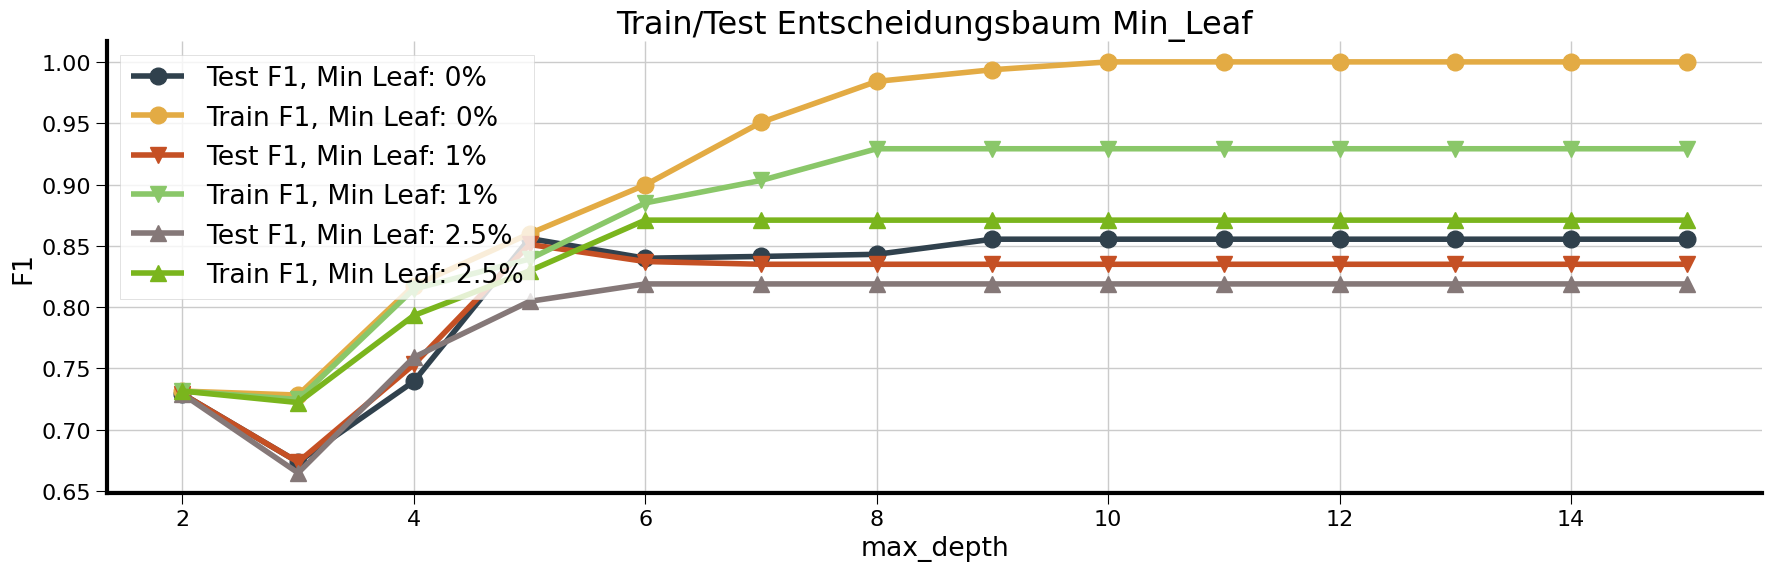

In [32]:
# Plotte Lineare Regression für Elektro Motor
fig, ax = plt.subplots(1, 1, figsize=half_plot_size)


filled_markers
for i, leaf in enumerate(['0%', '1%', '2.5%']):
    ax.plot(depth,test_all[i], '-'+filled_markers[i], label='Test F1, Min Leaf: ' + leaf)
    ax.plot(depth,train_all[i], '-'+filled_markers[i], label='Train F1, Min Leaf: '+ leaf)

ax.legend()
plt.title('Train/Test Entscheidungsbaum Min_Leaf')
plt.ylabel('F1')
plt.xlabel('max_depth')
plt.tight_layout()
plt.show()

# Eigenschaften CART

* Der Algorithmus ist gierig (greedy)
    * Auf jeder Stufe wird die beste Entscheidung getroffen.
    * Das entspricht nicht notwendigerweise der insgesamt besten Entscheidung.

* Rechenintensiv
    * Insbesondere für viele Parameter
    * Eine hohe Anzahl von Datensätzen

* Transparent
    * Entscheidungsbäume sind einfach zu erklären

# Steckbrief Entscheidungsbaum

<center><img src="img/tafel_cart.png" width=60% class="stretch"></center>

# Welches Modell für welche Verteilung?

<center><img src="img/tafel_grenzen.png" width=70% class="stretch"></center>

* Es sind drei unterschiedliche Verteilungen einer binären Klassifikation gegeben. 
* Welches der bekannten Modelle (logistische Regression; k-NN; Entscheidungsbaum) kann mit der geringsten Komplexität den jeweiligen Zusammenhang modellieren?

# Zusammenfassung

* Entscheidungsbäume als Modell für Klassifikation
    * Transparent
    * Einfach zu trainieren
    * Mächtig
